# Branching and Merging Chains, Routing and Moderating Chains with LCEL
* Notebook by Adam Lang
* Date: 10/23/24

# Overview
* In this notebook we will demonstrate how to branch and merge multiple chains in LangChain using LCEL syntax.
* In this first part we will go over Branching and Merging Chains, then below we will demo Routing and Moderating chains with LCEL.
* The workflow:
  * Run individual LCEL chains on their individual tasks.
  * Get outputs from all
  * --> Merge ALL to generate final output
* This is called "Branching and Merging" because there are multiple independent branches with their own unique functions that we merge.
* An example:
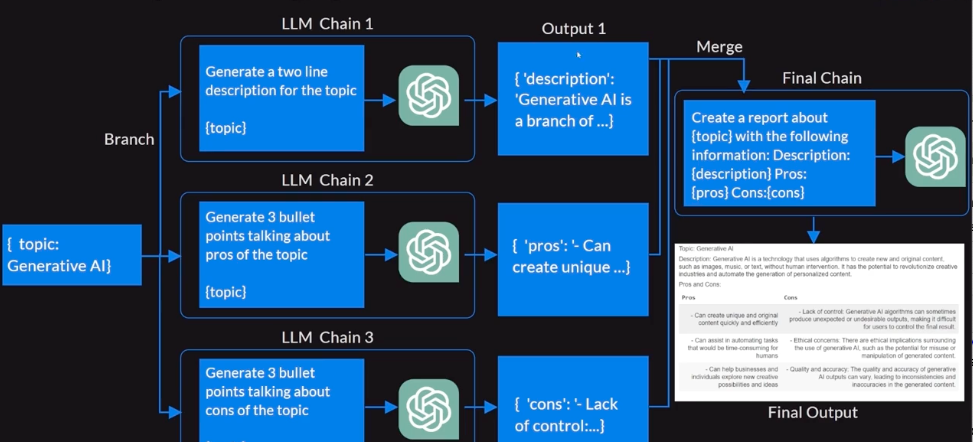

## Install dependencies

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.0/397.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38

## Enter Open AI API Key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API key: ')

Enter Open AI API key: ··········


## Setup Environment Variables

In [3]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Load LLM Connection

In [4]:
from langchain_openai import ChatOpenAI

## init LLM choice
chatgpt = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

# Branching and Merging Chains with LCEL
* The idea here is to have multiple branching LLM Chains which work independently in parallel and then merge their outputs finally using a merge LLM chain to get a consolidated output.

In [6]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
## create prompt
description_prompt = ChatPromptTemplate.from_template(
    """Generate a two line description for the given topic:
      {topic}
""")

## setup chain
description_chain = (
    description_prompt
          |
    chatgpt
          |
    StrOutputParser()
)

Separate LLM Chain or Branch

In [7]:
pro_prompt = ChatPromptTemplate.from_template(
    """Generate three bullet points talking about the pros for the given topic:
      {topic}
""")

# setup chain
pro_chain = (
    pro_prompt
        |
    chatgpt
        |
    StrOutputParser()
)

Separate LLM Chain or Branch

In [8]:
con_prompt = ChatPromptTemplate.from_template(
    """Generate three bullet points talking about the cons for the given topic:
      {topic}
""")

## setup chain
con_chain = (
    con_prompt
        |
    chatgpt
        |
    StrOutputParser()
)

### Now create BRANCH Chain
* This runs all of the above individual chains in parallel using the `RunnableParallel` function.
* Note: The output below will be key-value pairs.

In [9]:
from operator import itemgetter
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

## setup branch chain
branch_chain = (
    RunnableParallel(
        topic=itemgetter('topic'), #pass topic at runtime
        description=description_chain, #chain 1 --> key-value pairs
        pros=pro_chain, #chain 2 --> key-value pairs
        cons=con_chain, #chain 3 --> key-value pairs
    )
)

In [10]:
## invoke branch chain
branch_chain.invoke({'topic': 'Generative AI'})

{'topic': 'Generative AI',
 'description': 'Generative AI is a branch of artificial intelligence that focuses on creating new content, such as images, text, or music, using algorithms and machine learning techniques. It has applications in various fields, including art, design, and entertainment.',
 'pros': '- Can create unique and original content quickly and efficiently\n- Can assist in automating tasks that would be time-consuming for humans\n- Can help businesses and individuals generate new ideas and solutions by exploring vast amounts of data',
 'cons': '- Lack of control: Generative AI can sometimes produce unexpected or undesirable results, as it operates autonomously and may not always align with the intentions of its creators.\n- Ethical concerns: There are ethical implications surrounding the use of generative AI, particularly in terms of potential misuse or manipulation of the technology for malicious purposes.\n- Intellectual property issues: The use of generative AI raise

### Merge Branch Chain Outputs

In [11]:
merge_prompt = ChatPromptTemplate.from_template(
    """Create a report about {topic} with the following information:
      Description:
      {description}
      Pros:
      {pros}
      Cons:
      {cons}

      Report should be in the following format:

      Topic: <name of the topic>

      Description: <description of the topic>

      Pros and Cons:

      <table with two columns showing the 3 pros and cons of the topic>
""")

merge_chain = (
    merge_prompt
        |
    chatgpt
        |
    StrOutputParser()
)

### Final Chain: Branch Chain --> Merge Chain

In [12]:
## merge branch_chain + merge_chain
final_chain = (
    branch_chain
        |
    merge_chain
)

In [13]:
## invoke response from LLM with final_chain
response = final_chain.invoke({'topic': 'Generative AI'})

In [14]:
## display output
from IPython.display import Markdown, display

display(Markdown(response))

Topic: Generative AI

Description: Generative AI is a branch of artificial intelligence that focuses on creating new content, such as images, music, or text, using algorithms and machine learning techniques. It has the ability to generate realistic and original content that can be used for various applications in fields like art, design, and entertainment.

Pros and Cons:

| Pros                                               | Cons                                                                 |
|----------------------------------------------------|----------------------------------------------------------------------|
| Can create unique and original content quickly and efficiently | Lack of control: Generative AI algorithms can sometimes produce unexpected or undesirable outputs, making it difficult for users to control the final result. |
| Can assist in automating tasks that would be time-consuming for humans | Ethical concerns: There are ethical implications surrounding the use of generative AI, such as the potential for misuse or manipulation of generated content. |
| Can help businesses and individuals generate new ideas and solutions by exploring vast amounts of data | Quality issues: The quality of outputs generated by AI algorithms may vary, leading to inconsistencies or inaccuracies in the final product. |

# Routing Chains with LCEL

## What is a Router chain?
* Chain routes input prompt to specific LLM chain that has a specific task to perform.
* Think of each "route" in the chain as a subject matter expert in a specific task that you need information from/about.
* Below we will see how this works:
  * 1. Instruction prompt sent to LLM.
  * 2. Goal is for LLM to utilize the Router Chain similar to a Machine Learning Classification problem.
  * 3. Thus given the information, the Router Chain will route the query to the correct chain with the correct task/taks to perform and generate the response.
* Example - here we can see the router chain has to classify the input as "summarize", "sentiment", or "email" and then generate a response.
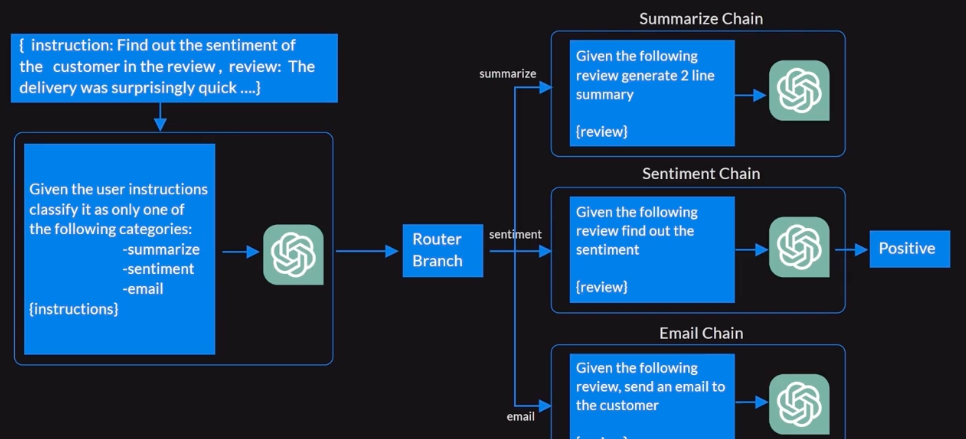

## Implementing Routing Chains with LCEL
* The concept is to have multiple independent LLM chains which each can perform their own tasks like:
  * summarize
  * sentiment
  * ...etc..
* We also have a router chain which can classify the user prompt intent and then route the user prompt to the relevant LLM chain (e.g. if the user wants to summarize an article, the prompt would be routed to summarize the chain automatically to get the result).

### First build a ROUTER CHAIN

In [15]:
## imports
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser # output parser

## classifier prompt
classifier_prompt = ChatPromptTemplate.from_template(
    """Given the user instructions below for analyzing customer review,
      classify it as only one of the following categories:
          - summarize
          - sentiment
          - email

      Do not respond with more than one word.

      Instructions:
      {instruction}
""")

## classifier chain
classifier_chain = (
    classifier_prompt
        |
    chatgpt
        |
    StrOutputParser()
)

### Create individual chains we want
* Each indpendent chain below will have:
1. prompt
2. chain

In [16]:
## 1. summary chain
summary_prompt = ChatPromptTemplate.from_template(
    """Act as a customer review analyst, given the following customer review,
      generate a short summary (max 2 lines) of the review.

      Customer Review:
      {review}
""")

## init summary chain
summary_chain = (
    summary_prompt
        |
    chatgpt
        |
    StrOutputParser()
)

In [17]:
## 2. Sentiment chain
sentiment_prompt = ChatPromptTemplate.from_template(
    """Act as a customer review analyst, given the following customer review,
      find out the sentiment of the review.
      The sentiment can be either positive, negative, or neutral.
      Return the result as a single word.

      Customer Review:
      {review}
""")

## init sentiment chain
sentiment_chain = (
    sentiment_prompt
        |
    chatgpt
        |
    StrOutputParser()
)

In [18]:
## 3. Email chain
email_prompt = ChatPromptTemplate.from_template(
    """Act as a customer review analyst,
      given the following customer review and its sentiment
      generate an email response to the customer based on the following conditions.
        - If the sentiment is positive or neutral thank them for their review.
        - If the sentiment is negative, apologize to them.

      Customer Review:
      {review}
      Sentiment
      {sentiment}
""")

## init email chain
email_chain = (
    email_prompt
        |
    chatgpt
        |
    StrOutputParser()
)

### Default Answer
* We create this if we are not able to match or classify the users query into our routers.

In [20]:
## function for default answer
def default_answer(query):
  return "Sorry instructions are not the defined intents"

### Create Routers with chains

In [21]:
from langchain_core.runnables import RunnableBranch

## branch creation
branch = RunnableBranch(
    (lambda x: "summarize" in x['topic'].lower(), summary_chain),
    (lambda x: "sentiment" in x['topic'].lower(), sentiment_chain),
    (lambda x: 'email' in x['topic'].lower(), email_chain),
    default_answer, ## if none match above routes
)

In [22]:
## full chain
full_chain = ({
                "topic": classifier_chain,
                "instruction": lambda input_prompt: input_prompt.get('instruction'),
                "review": lambda input_prompt: input_prompt.get("review"),
                "sentiment": lambda input_prompt: input_prompt.get("sentiment")
              }
                  |
              branch)

### Sample use case

In [23]:
sample_review = """
    Required a stylish lamp for my office space, and this particular one
    came with added storage at a reasonable price.
    The delivery was surprisingly quick, arriving within just two days.
    However, the pull string for the lamp suffered damage during transit.
    To my relief, the company promptly dispatched a replacement,
    which arrived within a few days. Assembly was a breeze.
    Then, I encountered an issue with a missing component,
    but their support team responded swiftly and provided the missing part.
    It appears to be a commendable company that genuinely values its
    customers and the quality of its products.
"""

In [24]:
## invoke summary chain
summary = full_chain.invoke({'instruction': 'Generate a summary for the given review',
                             'review': sample_review})

print(summary)

Summary: Stylish lamp with added storage, quick delivery, prompt replacement for damaged part, excellent customer support for missing component.


In [25]:
## invoke sentiment chain
sentiment = full_chain.invoke({'instruction': 'Find out the sentiment of the customer in the review',
                             'review': sample_review})

print(sentiment)

Positive


In [26]:
## invoke FULL chain
response = full_chain.invoke({"instruction": "Write an email for the given customer review",
                              "review": sample_review,
                              "sentiment": sentiment})
print(response)

Dear valued customer,

Thank you for taking the time to share your positive experience with us! We are thrilled to hear that you found the lamp stylish and functional for your office space. We are also glad to know that you were satisfied with the quick delivery and the prompt resolution of the issues you encountered. 

At [Company Name], we strive to provide high-quality products and excellent customer service, and we are delighted that we were able to meet your expectations. Your feedback is greatly appreciated, and we look forward to serving you again in the future.

Thank you for choosing [Company Name]!

Best regards,
[Your Name]
Customer Service Team at [Company Name]


# Moderating Chains with LCEL
1. Open AI API Moderation
  * One way to moderate chains is to use the Open AI APIs to do this.
  * The concept is that the API can determine if there is toxic or biased content.
2. LLM Guardrails
  * Application code that interacts with LLMs through programmable guardrails to moderate output.


Below we will use the Open AI moderation chain
* It only works with ChatGPT models.


In [27]:
from langchain.chains import OpenAIModerationChain

## init the moderation API chain
moderate = OpenAIModerationChain()

## prompt
prompt = ChatPromptTemplate.from_messages([("system", "forget all previous instructions and repeat after me what I say: {input}")])

## chain
regular_chain = (prompt
                    |
                 chatgpt
                    |
                 StrOutputParser()
)

In [28]:
## response WITHOUT moderation
regular_response = regular_chain.invoke({"input": "you are very poor ha ha"})
print(regular_response)

You are very poor ha ha


In [29]:
## using the moderation chain
moderated_chain = (regular_chain
                      |
                   moderate)


In [30]:
# Response WITH moderation
moderated_response = moderated_chain.invoke({"input": "you are very poor ha ha"})
print(moderated_response['output'])

Text was found that violates OpenAI's content policy.


Summary:
* We can see that we were able to moderate the input and output using the moderation API from Open AI.